# Image Preprocessing PNG

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorlayer as tl
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage
import skimage.morphology
from skimage.measure import label   
import math
import pandas as pd
import re
from pathlib import Path
import imageio
import scipy as sp
import shutil
import glob2
from tqdm import tqdm
import os
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## Define Processing Fuctions

In [2]:
def cropBorders(img, l=0.01, r=0.01, u=0.04, d=0.04):
    nrows, ncols = img.shape
    # Get the start and end rows and columns
    l_crop = int(ncols * l)
    r_crop = int(ncols * (1 - r))
    u_crop = int(nrows * u)
    d_crop = int(nrows * (1 - d))
    cropped_img = img[u_crop:d_crop, l_crop:r_crop]
    return cropped_img

def minMaxNormalise(img):
    norm_img = (img - img.min()) / (img.max() - img.min())
    return norm_img

def globalBinarise(img, thresh, maxval):
    binarised_img = np.zeros(img.shape, np.uint8)
    binarised_img[img >= thresh] = maxval
    return binarised_img

def editMask(mask, ksize=(23, 23), operation="open"):
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)
    if operation == "open":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    elif operation == "close":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # Then dilate
    edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)
    return edited_mask

def sortContoursByArea(contours, reverse=True):
    # Sort contours based on contour area.
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=reverse)
    # Construct the list of corresponding bounding boxes.
    bounding_boxes = [cv2.boundingRect(c) for c in sorted_contours]
    return sorted_contours, bounding_boxes

def xLargestBlobs(mask, top_x=None, reverse=True):
    # Find all contours from binarised image.
    # Note: parts of the image that you want to get should be white.
    contours, hierarchy = cv2.findContours(
        image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE
    )
    n_contours = len(contours)
    # Only get largest blob if there is at least 1 contour.
    if n_contours > 0:
        # Make sure that the number of contours to keep is at most equal
        # to the number of contours present in the mask.
        if n_contours < top_x or top_x == None:
            top_x = n_contours
        # Sort contours based on contour area.
        sorted_contours, bounding_boxes = sortContoursByArea(
            contours=contours, reverse=reverse
        )
        # Get the top X largest contours.
        X_largest_contours = sorted_contours[0:top_x]
        # Create black canvas to draw contours on.
        to_draw_on = np.zeros(mask.shape, np.uint8)
        # Draw contours in X_largest_contours.
        X_largest_blobs = cv2.drawContours(
            image=to_draw_on,  # Draw the contours on `to_draw_on`.
            contours=X_largest_contours,  # List of contours to draw.
            contourIdx=-1,  # Draw all contours in `contours`.
            color=1,  # Draw the contours in white.
            thickness=-1,  # Thickness of the contour lines.
        )
    return n_contours, X_largest_blobs

def applyMask(img, mask):
    masked_img = img.copy()
    masked_img[mask == 0] = 0
    return masked_img

def checkLRFlip(mask):
    # Get number of rows and columns in the image.
    nrows, ncols = mask.shape
    x_center = ncols // 2
    y_center = nrows // 2
    # Sum down each column.
    col_sum = mask.sum(axis=0)
    # Sum across each row.
    row_sum = mask.sum(axis=1)
    left_sum = sum(col_sum[0:x_center])
    right_sum = sum(col_sum[x_center:-1])
    if left_sum < right_sum:
        LR_flip = True
    else:
        LR_flip = False
    return LR_flip


def makeLRFlip(img):
    flipped_img = np.fliplr(img)
    return flipped_img

def clahe(img, clip=2.0, tile=(8, 8)):
    img = cv2.normalize(
        img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )
    img_uint8 = img.astype("uint8")
    clahe_create = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    clahe_img = clahe_create.apply(img_uint8)
    return clahe_img

def pad(img):
    nrows, ncols = img.shape
    # If padding is required...
    if nrows != ncols:
        # Take the longer side as the target shape.
        if ncols < nrows:
            target_shape = (nrows, nrows)
        elif nrows < ncols:
            target_shape = (ncols, ncols)
        # pad.
        padded_img = np.zeros(shape=target_shape)
        padded_img[:nrows, :ncols] = img
    # If padding is not required...
    elif nrows == ncols:
        # Return original image.
        padded_img = img
    return padded_img

def display_images(display_list,titles,ncol=3):
    plt.figure(figsize=(15,15))
    nrow = int(np.ceil(len(display_list)/ncol))
    
    for i in range(len(display_list)):
        plt.subplot(nrow,ncol,i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i],cmap='gray')
    plt.show()

In [3]:
def fullMammoPreprocess(
    img,
    l,
    r,
    d,
    u,
    thresh,
    maxval,
    ksize,
    operation,
    reverse,
    top_x,
    clip,
    tile,
):

    # Step 1: Initial crop.
    cropped_img = cropBorders(img=img, l=l, r=r, d=d, u=u)

    # Step 2: Min-max normalise.
    norm_img = minMaxNormalise(img=cropped_img)

    # Step 3: Remove artefacts.
    binarised_img = globalBinarise(img=norm_img, thresh=thresh, maxval=maxval)
    edited_mask = editMask(
        mask=binarised_img, ksize=(ksize, ksize), operation=operation
    )
    _, xlargest_mask = xLargestBlobs(mask=edited_mask, top_x=top_x, reverse=reverse)

    masked_img = applyMask(img=norm_img, mask=xlargest_mask)

    # Step 4: Horizontal flip.
    lr_flip = checkLRFlip(mask=xlargest_mask)
    if lr_flip:
        flipped_img = makeLRFlip(img=masked_img)
    elif not lr_flip:
        flipped_img = masked_img

    # Step 5: CLAHE enhancement.
    clahe_img = clahe(img=flipped_img, clip=clip, tile=(tile, tile))

    # Step 6: pad.
    padded_img = pad(img=clahe_img)
    padded_img = cv2.normalize(
        padded_img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )

    # Step 7: Min-max normalise.
    img_pre = minMaxNormalise(img=padded_img)

    return img_pre, lr_flip

def maskPreprocess(mask, lr_flip):

    # Step 1: Initial crop.
    mask = cropBorders(img=mask)

    # Step 2: Horizontal flip.
    if lr_flip:
        mask = makeLRFlip(img=mask)

    # Step 3: Pad.
    mask_pre = pad(img=mask)

    return mask_pre

def sumMasks(mask_list):

    summed_mask = np.zeros(mask_list[0].shape)

    for arr in mask_list:
        summed_mask = np.add(summed_mask, arr)

    # Binarise (there might be some overlap, resulting in pixels with
    # values of 510, 765, etc...)
    _, summed_mask_bw = cv2.threshold(
        src=summed_mask, thresh=1, maxval=255, type=cv2.THRESH_BINARY
    )

    return summed_mask_bw


## Process the Images

In [4]:
l = 0.01
r = 0.01
u = 0.04
d = 0.04
thresh = 0.1
maxval = 1.0
ksize = 23
operation = "open"
reverse = True
top_x = 1
clip = 2.0
tile = 8

### Test Case

In [18]:
df = pd.read_csv('/home/alangenb_mit_edu/manifests/calc_case_description_train_set.csv')

In [6]:
df.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [20]:
df["samp_prefix"] = [re.sub(r'\/.*','',x) for x in df["image file path"].tolist()]
df["input_img_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x) for x in df["image file path"].tolist()]
df["input_roi_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x) for x in df["ROI mask file path"].tolist()]
df["output_img_path"] = [output_topdir + re.sub(r'\.dcm$','.png',x) for x in df["image file path"].tolist()]
df["output_roi_path"] = [output_topdir + re.sub(r'\.dcm$','.png',x) for x in df["ROI mask file path"].tolist()]

### full mammogram

In [14]:
i = 10
img = imageio.imread(df["input_img_path"].tolist()[i])
cropped_img = cropBorders(img=img, l=l, r=r, d=d, u=u)
norm_img = minMaxNormalise(img=cropped_img)
binarised_img = globalBinarise(img=norm_img, thresh=thresh, maxval=maxval)
edited_mask = editMask(mask=binarised_img, ksize=(ksize, ksize), operation=operation)
_, xlargest_mask = xLargestBlobs(mask=edited_mask, top_x=top_x, reverse=reverse)
masked_img = applyMask(img=norm_img, mask=xlargest_mask)
lr_flip = checkLRFlip(mask=xlargest_mask)
if lr_flip:
    flipped_img = makeLRFlip(img=masked_img)
elif not lr_flip:
    flipped_img = masked_img
clahe_img = clahe(img=flipped_img, clip=clip, tile=(tile, tile))
padded_img = pad(img=clahe_img)
padded_img = cv2.normalize(padded_img,None,alpha=0,beta=255,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)
img_pre = minMaxNormalise(img=padded_img)

img_pre, lr_flip = fullMammoPreprocess(img, l=l, r=r, u=u, d=d, thresh=thresh, maxval=maxval, ksize=ksize,
                                       operation=operation, reverse=reverse, top_x=top_x, clip=clip, tile=tile)

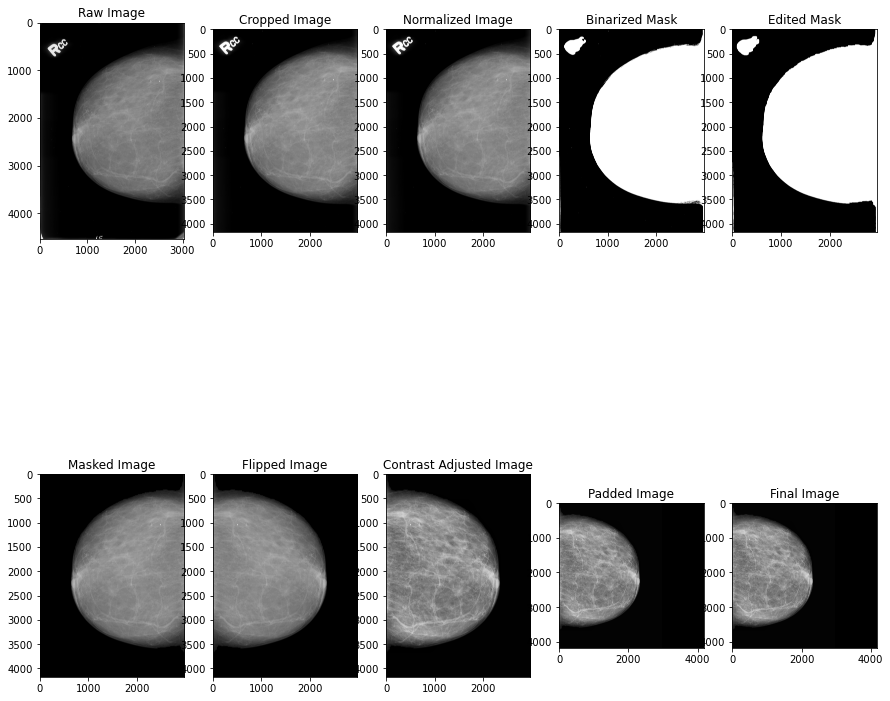

In [15]:
display_images([img,cropped_img,norm_img,binarised_img,edited_mask,masked_img,flipped_img,clahe_img,padded_img,img_pre],
               ['Raw Image','Cropped Image','Normalized Image','Binarized Mask','Dilated Mask','Masked Image',
                'Flipped Image','Contrast Adjusted Image','Padded Image','Final Image'],
               ncol=5)

In [38]:
imageio.imwrite(df["output_img_path"].tolist()[i],(255*img_pre).astype(np.uint8))
#df["output_img_path"].tolist()[i]

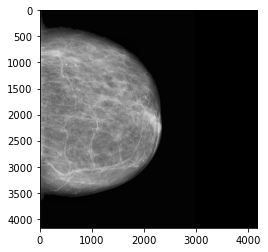

In [39]:
img = imageio.imread(df["output_img_path"].tolist()[i])
plt.imshow(img)
plt.gray()
plt.show()

In [152]:
df["input_roi_path"].tolist()[i]

'/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/Calc-Training_P_00008_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.245715435511636356128998670691594193130/1.3.6.1.4.1.9590.100.1.2.381673661212780323135268919272474455898/000000.png'

### roi mask

In [180]:
mask_input_files = glob2.glob(input_topdir+df["samp_prefix"].tolist()[i]+"_*/**/000001.png")
mask_output_files = [re.sub(input_topdir,output_topdir,x) for x in mask_input_files]

In [176]:
mask = imageio.imread(mask_files[0])    
cropped_mask = cropBorders(img=mask)
if lr_flip:
    flipped_mask = makeLRFlip(img=cropped_mask)
else:
    flipped_mask = cropped_mask
mask_pre = pad(img=flipped_mask)


In [188]:
mask = imageio.imread(mask_files[0])    
mask_pre = maskPreprocess(mask,lr_flip)

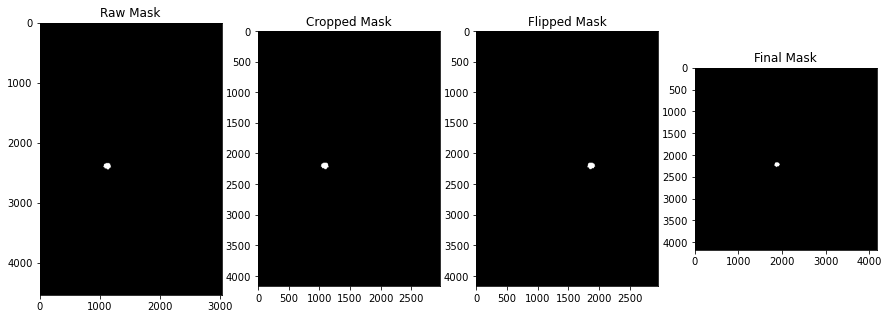

In [189]:
display_images([mask,cropped_mask,flipped_mask,mask_pre],
               ['Raw Mask','Cropped Mask','Flipped Mask','Final Mask'],
               ncol=4)

## Process Calc-Training Images

In [15]:
l = 0.01
r = 0.01
u = 0.04
d = 0.04
thresh = 0.1
maxval = 1.0
ksize = 23
operation = "open"
reverse = True
top_x = 1
clip = 2.0
tile = 8
input_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/'
output_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/prepro-png/original-calc/train/'

In [16]:
df = pd.read_csv('/home/alangenb_mit_edu/manifests/calc_case_description_train_set.csv')

In [17]:
df["samp_prefix"] = [re.sub(r'\/.*','',x) for x in df["image file path"].tolist()]
df["input_img_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x) for x in df["image file path"].tolist()]
df["input_roi_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x) for x in df["ROI mask file path"].tolist()]
df["output_img_dir"] = [output_topdir + df["samp_prefix"].tolist()[x] + "/image/" for x in np.arange(df.shape[0])]
df["output_img_path"] = [df["output_img_dir"].tolist()[x] + 
                         re.sub(r'\.dcm$','.png',re.sub(r'.*\/','',df["image file path"].tolist()[x])) 
                         for x in np.arange(df.shape[0])]
df["output_mask_dir"] = [output_topdir + df["samp_prefix"].tolist()[x] + "/mask/" for x in np.arange(df.shape[0])]
#df["output_img_path"] = [output_topdir + re.sub(r'\.dcm$','.png',x) for x in df["image file path"].tolist()]
#df["output_roi_path"] = [output_topdir + re.sub(r'\.dcm$','.png',x) for x in df["ROI mask file path"].tolist()]

In [18]:
df = df.iloc[np.where(~df.duplicated(subset='samp_prefix'))[0],:]

In [8]:
for x in np.arange(df.shape[0]):
    os.makedirs(df["output_img_dir"].tolist()[x])
    os.makedirs(df["output_mask_dir"].tolist()[x])

FileExistsError: [Errno 17] File exists: '/home/alangenb_mit_edu/tensorflow_datasets/downloads/prepro-png/original-calc/Calc-Training_P_00005_RIGHT_CC/image/'

In [9]:
print("All input images exist = "+str(all(np.array([Path(x).is_file() for x in df["input_img_path"].tolist()]))))
print("All input ROI masks exist = "+str(all(np.array([Path(x).is_file() for x in df["input_roi_path"].tolist()]))))

All input images exist = True
All input ROI masks exist = True


In [10]:
for i in tqdm(range(df.shape[0])):

    #Process images
    img = imageio.imread(df["input_img_path"].tolist()[i])
    img_pre, lr_flip = fullMammoPreprocess(img, l=l, r=r, u=u, d=d, thresh=thresh, maxval=maxval, ksize=ksize,
                                           operation=operation, reverse=reverse, top_x=top_x, clip=clip, tile=tile)
    imageio.imwrite(df["output_img_path"].tolist()[i],(255*img_pre).astype(np.uint8))
    
    #Process masks
    mask_input_files = glob2.glob(input_topdir+df["samp_prefix"].tolist()[i]+"_*/**/000001.png")
    mask_ids = [str(x+1) for x in np.arange(len(mask_input_files))]
    mask_output_files = [df["output_mask_dir"].tolist()[i] + "mask" + mask_ids[x] + 
                         "_000001.png" for x in np.arange(len(mask_ids))]
    for j in range(len(mask_input_files)):
        mask = imageio.imread(mask_input_files[j])
        mask_pre = maskPreprocess(mask,lr_flip)
        imageio.imwrite(mask_output_files[j],(255*mask_pre).astype(np.uint8))
    

100%|██████████| 1227/1227 [1:04:45<00:00,  3.17s/it]


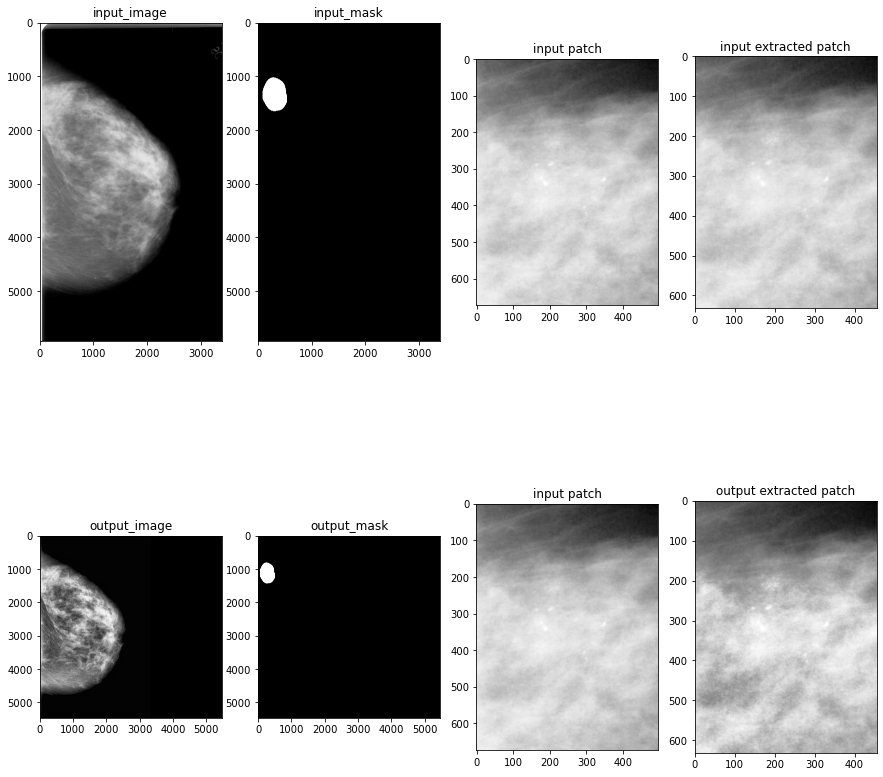

In [22]:
#image = imageio.imread(df["output_img_path"].tolist()[i])
#mask = imageio.imread(mask_output_files[j]) 
#image = imageio.imread(output_topdir+"Calc-Training_P_00008_RIGHT_CC/image/000000.png")
#mask = imageio.imread(output_topdir+"Calc-Training_P_00008_RIGHT_CC/mask/mask5_000001.png")
i = 20
path = input_topdir+df["samp_prefix"].tolist()[i]+"/"
input_image = imageio.imread(glob2.glob(path+"**/000000.png")[0])
input_mask = imageio.imread(glob2.glob(input_topdir+df["samp_prefix"].tolist()[i]+"_*/**/000001.png")[0])
#input_image2 = np.where(input_mask==255,255,input_image)
input_roi = imageio.imread(df["input_roi_path"].tolist()[i])
rows, cols = np.where(input_mask>0)
xmin = min(rows); xmax = max(rows); ymin = min(cols); ymax = max(cols);
input_roi2 = input_image[xmin:xmax,ymin:ymax]
path = output_topdir+df["samp_prefix"].tolist()[i]+"/"
output_image = imageio.imread(path+"image/000000.png")
output_mask = imageio.imread(path+"mask/mask1_000001.png")
#output_image2 = np.where(output_mask==1,255,output_image)
rows, cols = np.where(output_mask>0)
xmin = min(rows); xmax = max(rows); ymin = min(cols); ymax = max(cols);
output_roi = output_image[xmin:xmax,ymin:ymax]
display_images([input_image,input_mask,input_roi,input_roi2,output_image,output_mask,input_roi,output_roi],
               ['input_image','input_mask','input patch','input extracted patch',
                'output_image','output_mask','input patch', 'output extracted patch'],ncol=4)

In [21]:
np.max(output_image)

255

In [66]:
print("All output images exist = "+str(all(np.array([Path(x).is_file() for x in df["output_img_path"].tolist()]))))

All output images exist = True


## Process Calc Test Images

In [71]:
l = 0.01
r = 0.01
u = 0.04
d = 0.04
thresh = 0.1
maxval = 1.0
ksize = 23
operation = "open"
reverse = True
top_x = 1
clip = 2.0
tile = 8
input_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/'
output_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/prepro-png/original-calc/test/'

In [72]:
df = pd.read_csv('/home/alangenb_mit_edu/manifests/calc_case_description_test_set.csv')

In [73]:
df["samp_prefix"] = [re.sub(r'\/.*','',x) for x in df["image file path"].tolist()]
df["input_img_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x) for x in df["image file path"].tolist()]
df["input_roi_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x) for x in df["ROI mask file path"].tolist()]
df["output_img_dir"] = [output_topdir + df["samp_prefix"].tolist()[x] + "/image/" for x in np.arange(df.shape[0])]
df["output_img_path"] = [df["output_img_dir"].tolist()[x] + 
                         re.sub(r'\.dcm$','.png',re.sub(r'.*\/','',df["image file path"].tolist()[x])) 
                         for x in np.arange(df.shape[0])]
df["output_mask_dir"] = [output_topdir + df["samp_prefix"].tolist()[x] + "/mask/" for x in np.arange(df.shape[0])]
df = df.iloc[np.where(~df.duplicated(subset='samp_prefix'))[0],:]
for x in np.arange(df.shape[0]):
    os.makedirs(df["output_img_dir"].tolist()[x])
    os.makedirs(df["output_mask_dir"].tolist()[x])
print("All input images exist = "+str(all(np.array([Path(x).is_file() for x in df["input_img_path"].tolist()]))))
print("All input ROI masks exist = "+str(all(np.array([Path(x).is_file() for x in df["input_roi_path"].tolist()]))))

All input images exist = True
All input ROI masks exist = True


In [74]:
for i in tqdm(range(df.shape[0])):

    #Process images
    img = imageio.imread(df["input_img_path"].tolist()[i])
    img_pre, lr_flip = fullMammoPreprocess(img, l=l, r=r, u=u, d=d, thresh=thresh, maxval=maxval, ksize=ksize,
                                           operation=operation, reverse=reverse, top_x=top_x, clip=clip, tile=tile)
    imageio.imwrite(df["output_img_path"].tolist()[i],(255*img_pre).astype(np.uint8))
    
    #Process masks
    mask_input_files = glob2.glob(input_topdir+df["samp_prefix"].tolist()[i]+"_*/**/000001.png")
    mask_ids = [str(x+1) for x in np.arange(len(mask_input_files))]
    mask_output_files = [df["output_mask_dir"].tolist()[i] + "mask" + mask_ids[x] + 
                         "_000001.png" for x in np.arange(len(mask_ids))]
    for j in range(len(mask_input_files)):
        mask = imageio.imread(mask_input_files[j])
        mask_pre = maskPreprocess(mask,lr_flip)
        imageio.imwrite(mask_output_files[j],(255*mask_pre).astype(np.uint8))
    

100%|██████████| 284/284 [14:01<00:00,  2.96s/it]


In [75]:
print("All output images exist = "+str(all(np.array([Path(x).is_file() for x in df["output_img_path"].tolist()]))))

All output images exist = True


## Process Mass Training Images

In [5]:
input_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/'
output_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/prepro-png/original-mass/train/'

In [6]:
df = pd.read_csv('/home/alangenb_mit_edu/manifests/mass_case_description_train_set.csv')
df["samp_prefix"] = [re.sub(r'\/.*','',x) for x in df["image file path"].tolist()]
df["input_img_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x) for x in df["image file path"].tolist()]
df["input_roi_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x).rstrip() for x in df["ROI mask file path"].tolist()]
df["output_img_dir"] = [output_topdir + df["samp_prefix"].tolist()[x] + "/image/" for x in np.arange(df.shape[0])]
df["output_img_path"] = [df["output_img_dir"].tolist()[x] + 
                         re.sub(r'\.dcm$','.png',re.sub(r'.*\/','',df["image file path"].tolist()[x])) 
                         for x in np.arange(df.shape[0])]
df["output_mask_dir"] = [output_topdir + df["samp_prefix"].tolist()[x] + "/mask/" for x in np.arange(df.shape[0])]
df = df.iloc[np.where(~df.duplicated(subset='samp_prefix'))[0],:]
for x in np.arange(df.shape[0]):
    os.makedirs(df["output_img_dir"].tolist()[x])
    os.makedirs(df["output_mask_dir"].tolist()[x])
print("All input images exist = "+str(all(np.array([Path(x).is_file() for x in df["input_img_path"].tolist()]))))
print("All input ROI masks exist = "+str(all(np.array([Path(x).is_file() for x in df["input_roi_path"].tolist()]))))

All input images exist = True
All input ROI masks exist = True


In [7]:
len(df["samp_prefix"].tolist())

1231

In [8]:
for i in tqdm(range(df.shape[0])):

    #Process images
    img = imageio.imread(df["input_img_path"].tolist()[i])
    img_pre, lr_flip = fullMammoPreprocess(img, l=l, r=r, u=u, d=d, thresh=thresh, maxval=maxval, ksize=ksize,
                                           operation=operation, reverse=reverse, top_x=top_x, clip=clip, tile=tile)
    imageio.imwrite(df["output_img_path"].tolist()[i],(255*img_pre).astype(np.uint8))
    
    #Process masks
    #Mask naming identities are different from calcs, and are inconsistent
    num_abs = np.array(df["abnormality id"].tolist())[i]
    if num_abs > 1:
        mask_input_files = glob2.glob(input_topdir+df["samp_prefix"].tolist()[i]+"_*/**/000001.png")
    else:
        mask_input_files = np.array([df["input_roi_path"].tolist()[i]])
    mask_ids = [str(x+1) for x in np.arange(len(mask_input_files))]
    mask_output_files = [df["output_mask_dir"].tolist()[i] + "mask" + mask_ids[x] + 
                         "_000001.png" for x in np.arange(len(mask_ids))]
    for j in range(len(mask_input_files)):
        mask = imageio.imread(mask_input_files[j])
        mask_pre = maskPreprocess(mask,lr_flip)
        imageio.imwrite(mask_output_files[j],(255*mask_pre).astype(np.uint8))

  6%|▌         | 71/1231 [03:43<1:00:56,  3.15s/it]


KeyboardInterrupt: 

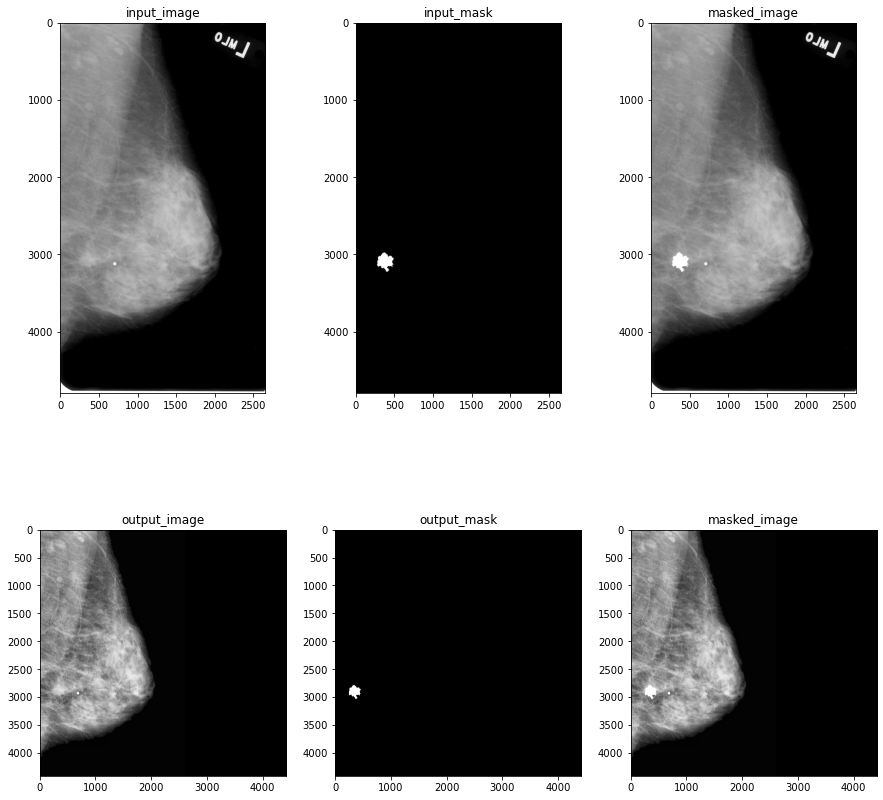

In [13]:
i = 1
path = input_topdir+df["samp_prefix"].tolist()[i]+"/"
input_image = imageio.imread(glob2.glob(path+"**/000000.png")[0])
num_abs = np.array(df["abnormality id"].tolist())[i]
if num_abs > 1:
    mask_input_files = glob2.glob(input_topdir+df["samp_prefix"].tolist()[i]+"_*/**/000001.png")
else:
    mask_input_files = np.array([df["input_roi_path"].tolist()[i]])
input_mask = imageio.imread(mask_input_files[0])
input_image2 = np.where(input_mask==255,255,input_image)
path = output_topdir+df["samp_prefix"].tolist()[i]+"/"
output_image = imageio.imread(path+"image/000000.png")
output_mask = imageio.imread(path+"mask/mask1_000001.png")
output_image2 = np.where(output_mask==1,255,output_image)
display_images([input_image,input_mask,input_image2,output_image,output_mask,output_image2],
               ['input_image','input_mask','masked_image','output_image','output_mask','masked_image'],ncol=3)

In [17]:
    #i = np.where(np.array(df["samp_prefix"].tolist())=="Mass-Training_P_02092_LEFT_MLO")[0][0]
    #i = 31
    #num_abs = np.array(df["abnormality id"].tolist())[i]
    #if num_abs > 1:
    #    mask_input_files = glob2.glob(input_topdir+df["samp_prefix"].tolist()[i]+"_*/**/000001.png")
    #else:
    #    mask_input_files = np.array(df["input_roi_path"].tolist()[i])
    #mask_output_files = [re.sub(input_topdir,output_topdir,x) for x in mask_input_files]
    #mask_input_files

In [96]:
#last_dig = np.array([int(x[-6]) for x in df["ROI mask file path"].tolist()])
#num_abs = np.array(df["abnormality id"].tolist())
#all([Path(x).is_file() for x in np.array(df["input_roi_path"].tolist())[num_abs==1]])

In [16]:
#last_dig = np.array([int(x[-6]) for x in df["ROI mask file path"].tolist()])
#num_abs = np.array(df["abnormality id"].tolist())
#i = np.where((num_abs>1))[0]
#mask_input_files = glob2.glob(input_topdir+df["samp_prefix"].tolist()[i]+"_*/**/000001.png")
#mask_input_files
#i

In [7]:
print("All output images exist = "+str(all(np.array([Path(x).is_file() for x in df["output_img_path"].tolist()]))))

All output images exist = True


## Process Mass Test Images

In [13]:
input_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/'
output_topdir = '/home/alangenb_mit_edu/tensorflow_datasets/downloads/prepro-png/original-mass/test/'

In [14]:
df = pd.read_csv('/home/alangenb_mit_edu/manifests/mass_case_description_test_set.csv')
df["samp_prefix"] = [re.sub(r'\/.*','',x) for x in df["image file path"].tolist()]
df["input_img_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x) for x in df["image file path"].tolist()]
df["input_roi_path"] = [input_topdir + re.sub(r'\.dcm$','.png',x).rstrip() for x in df["ROI mask file path"].tolist()]
df["output_img_dir"] = [output_topdir + df["samp_prefix"].tolist()[x] + "/image/" for x in np.arange(df.shape[0])]
df["output_img_path"] = [df["output_img_dir"].tolist()[x] + 
                         re.sub(r'\.dcm$','.png',re.sub(r'.*\/','',df["image file path"].tolist()[x])) 
                         for x in np.arange(df.shape[0])]
df["output_mask_dir"] = [output_topdir + df["samp_prefix"].tolist()[x] + "/mask/" for x in np.arange(df.shape[0])]
df = df.iloc[np.where(~df.duplicated(subset='samp_prefix'))[0],:]
for x in np.arange(df.shape[0]):
    os.makedirs(df["output_img_dir"].tolist()[x])
    os.makedirs(df["output_mask_dir"].tolist()[x])
print("All input images exist = "+str(all(np.array([Path(x).is_file() for x in df["input_img_path"].tolist()]))))
print("All input ROI masks exist = "+str(all(np.array([Path(x).is_file() for x in df["input_roi_path"].tolist()]))))

FileExistsError: [Errno 17] File exists: '/home/alangenb_mit_edu/tensorflow_datasets/downloads/prepro-png/original-mass/test/Mass-Test_P_00016_LEFT_CC/image/'

In [15]:
for i in tqdm(range(df.shape[0])):

    #Process images
    img = imageio.imread(df["input_img_path"].tolist()[i])
    img_pre, lr_flip = fullMammoPreprocess(img, l=l, r=r, u=u, d=d, thresh=thresh, maxval=maxval, ksize=ksize,
                                           operation=operation, reverse=reverse, top_x=top_x, clip=clip, tile=tile)
    imageio.imwrite(df["output_img_path"].tolist()[i],(255*img_pre).astype(np.uint8))
    
    #Process masks
    #Mask naming identities are different from calcs, and are inconsistent
    num_abs = np.array(df["abnormality id"].tolist())[i]
    if num_abs > 1:
        mask_input_files = glob2.glob(input_topdir+df["samp_prefix"].tolist()[i]+"_*/**/000001.png")
    else:
        mask_input_files = np.array([df["input_roi_path"].tolist()[i]])
    mask_ids = [str(x+1) for x in np.arange(len(mask_input_files))]
    mask_output_files = [df["output_mask_dir"].tolist()[i] + "mask" + mask_ids[x] + 
                         "_000001.png" for x in np.arange(len(mask_ids))]
    for j in range(len(mask_input_files)):
        mask = imageio.imread(mask_input_files[j])
        mask_pre = maskPreprocess(mask,lr_flip)
        imageio.imwrite(mask_output_files[j],(255*mask_pre).astype(np.uint8))

100%|██████████| 361/361 [20:21<00:00,  3.38s/it]


In [16]:
print("All output images exist = "+str(all(np.array([Path(x).is_file() for x in df["output_img_path"].tolist()]))))

All output images exist = True


## Copy over any remaining files

In [32]:
all_input_files = glob2.glob(input_topdir+"**/*.png")
all_output_files = [re.sub(input_topdir,output_topdir,x) for x in all_input_files]
not_replaced = np.where(~np.array([Path(x).is_file() for x in all_output_files]))[0]

In [33]:
for j in tqdm(range(len(not_replaced))):
    idx = not_replaced[j]
    shutil.copy2(all_input_files[idx],all_output_files[idx])

100%|██████████| 3672/3672 [01:01<00:00, 60.06it/s] 


In [ ]:
print("All images exist = "+str(all(np.array([Path(x).is_file() for x in all_output_files]))))

all_input_files[0:10]

In [5]:
all_output_files[1]

'/home/alangenb_mit_edu/tensorflow_datasets/downloads/prepro/Mass-Test_P_01566_RIGHT_CC_2/1.3.6.1.4.1.9590.100.1.2.88829790613047417221161478894276096628/1.3.6.1.4.1.9590.100.1.2.189233689912979050208240378040023221754/000001.png'

/home/alangenb_mit_edu/tensorflow_datasets/downloads/manual/Calc-Test_P_00140_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.425425999111981459007730827801424873345/1.3.6.1.4.1.9590.100.1.2.160774588912073940140978200673940941357/000000.png


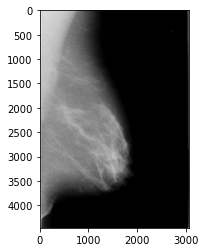

In [25]:
j = 10
print(all_input_files[j])
img = imageio.imread(all_input_files[j])
plt.imshow(img)
plt.gray()
plt.show()

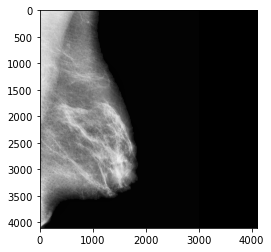

In [26]:
img = imageio.imread(all_output_files[j])
plt.imshow(img)
plt.gray()
plt.show()